# Setup

## Imports

In [1]:
from vaiutils import path_consts, plot_images, channels_last, merge, print_progress
from tqdm import tqdm_notebook
from time import time

All the torch related modules

In [2]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torch.autograd import Variable

## Load data and variables

In [3]:
for k, v in path_consts('MNIST', 'MNIST'):
    exec(k + '=v')

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(DIR_DATA, download=True, transform=transform)
test_dataset = MNIST(DIR_DATA, train=False, download=True, transform=transform)

In [5]:
batch_size = 64

In [6]:
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [7]:
imgs, labels = iter(train_data).next()

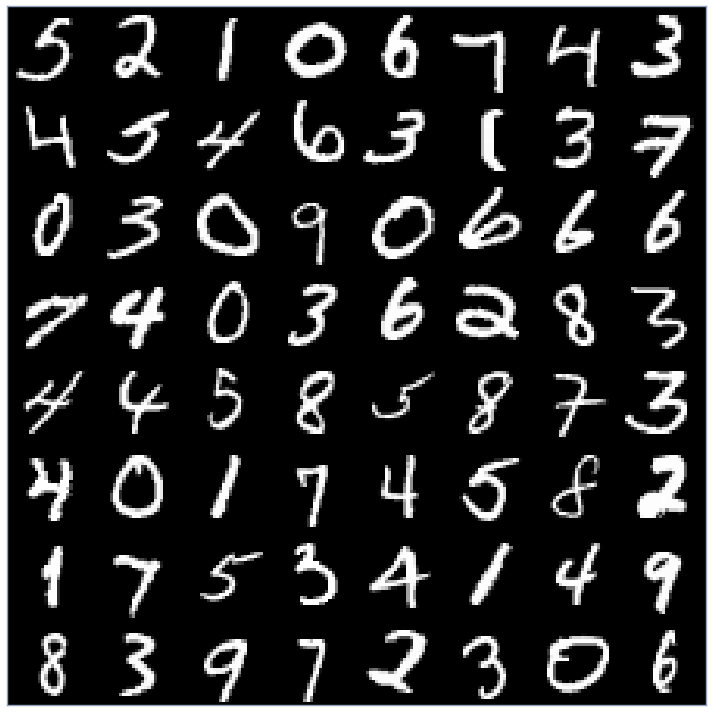

In [8]:
plot_images(channels_last(imgs.numpy()))

# Create model

In [140]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 2, padding=2)
        self.fc1 = nn.Linear(14 * 14 * 6, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.fc1(x.view(-1, 14 * 14 * 6))
        return x

# Train Model

In [141]:
model = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [84]:
def get_accuracy(scores, y_batch):
    y_pred = scores.cpu().data.numpy().argmax(1)
    return (y_pred == y_batch.cpu().data.numpy()).astype('float32').mean() * 100

In [85]:
def get_validation_metrics(use_total=False):
    if not use_total:
        x_batch, y_batch = iter(test_data).next()
        x_batch, y_batch = Variable(x_batch.cuda()), Variable(y_batch.cuda())

        scores = model.forward(x_batch)
        loss = criterion(scores, y_batch)
        return loss, get_accuracy(scores, y_batch)

    tot_loss = 0
    tot_acc = 0
    for batch, data in enumerate(tqdm_notebook(test_data)):
        x_batch, y_batch = data
        x_batch, y_batch = Variable(x_batch.cuda()), Variable(y_batch.cuda())

        scores = model.forward(x_batch)
        loss = criterion(scores, y_batch)
        tot_loss += loss
        tot_acc += get_accuracy(scores, y_batch)
    return tot_loss / len(test_data), tot_acc / len(test_data)

In [118]:
history = {'loss': [], 'loss_cpu': [],
           'acc': [], 'val_loss': [], 'val_acc': []}


def optimize(epochs=1):
    for epoch in tqdm_notebook(range(epochs)):
        for batch, data in enumerate(tqdm_notebook(train_data)):
            x_batch, y_batch = data
            x_batch, y_batch = Variable(
                x_batch.cuda()), Variable(y_batch.cuda())

            optimizer.zero_grad()
            scores = model.forward(x_batch)
            loss = criterion(scores, y_batch)
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                history['loss'].append(loss.cpu().data.numpy()[0])
                history['acc'].append(get_accuracy(scores, y_batch))
                val_loss, val_acc = get_validation_metrics()
                history['val_loss'].append(val_loss.cpu().data.numpy()[0])
                history['val_acc'].append(val_acc)

In [142]:
optimize()

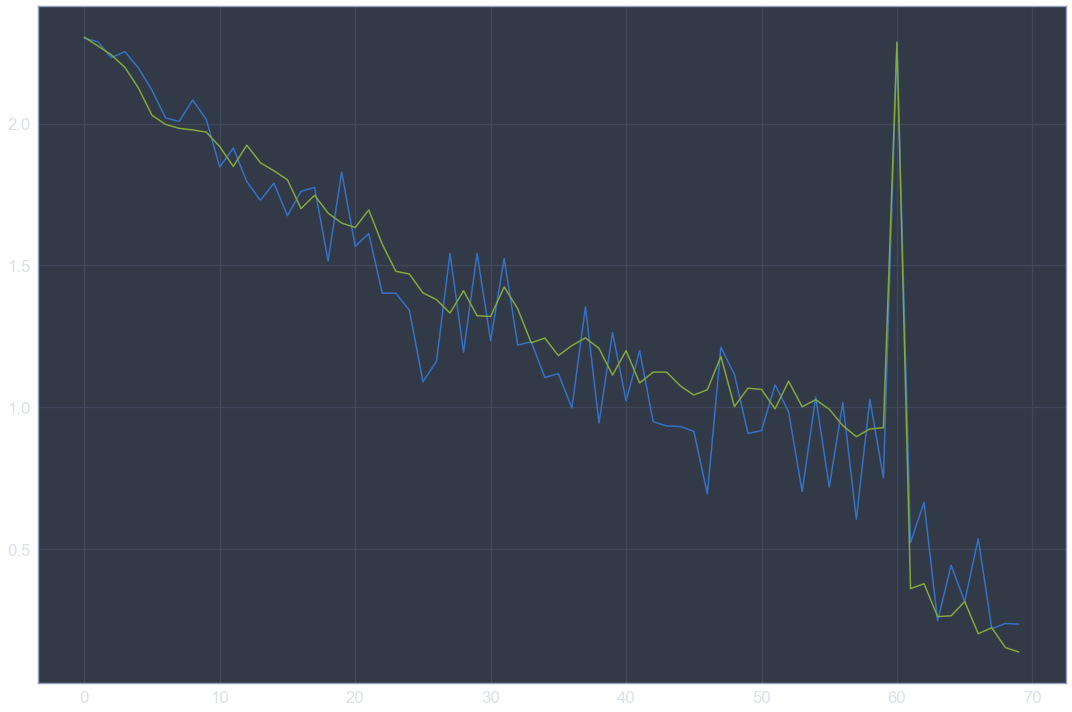

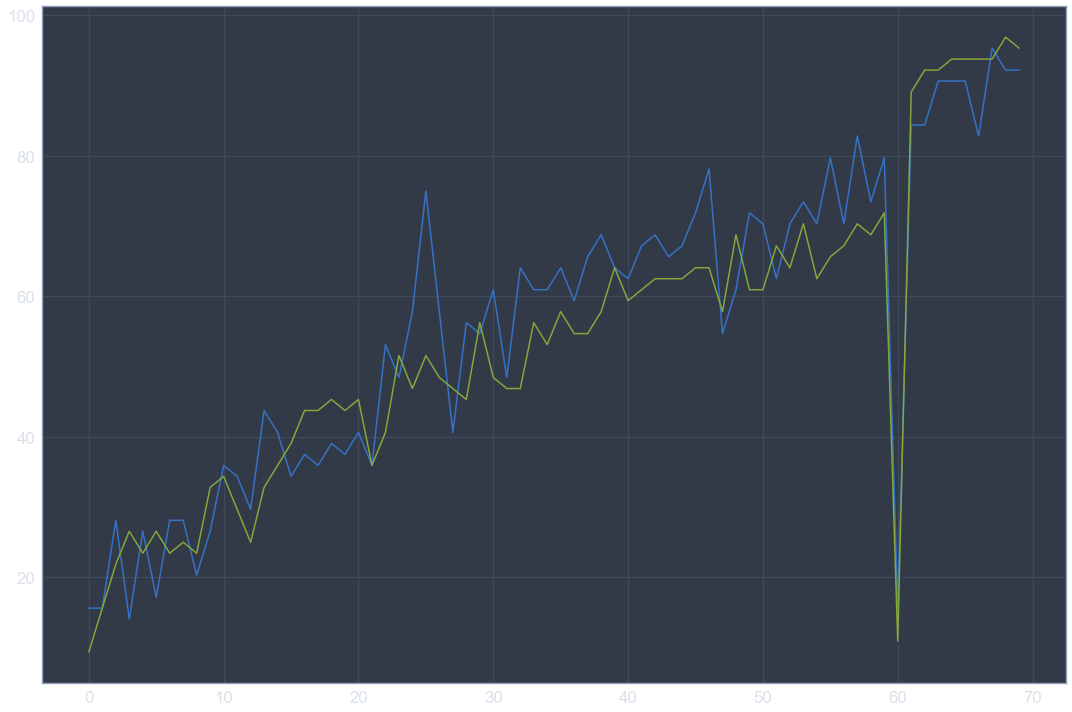

In [143]:
plot(history['loss'])
plot(history['val_loss'])
plt.show()
plot(history['acc'])
plot(history['val_acc'])

# Test Model

In [144]:
test_loss, test_acc = get_validation_metrics(use_total=True)

In [145]:
test_loss.cpu().data.numpy()[0], test_acc

(0.22975965, 93.495135927505331)